##Verify NVIDIA GPU Availability

#####Make sure you're using a GPU-equipped machine by going to "Runtime" -> "Change runtime type" in the top menu bar, and then selecting one of the GPU options in the Hardware accelerator section. Click Play on the following code block to verify that the NVIDIA GPU is present and ready for training.


In [ ]:
!nvidia-smi


Sat Nov 22 04:12:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

##Gather and Label Training Images

#####Before we start training,we need to gather images that is used for training the mask detection , in this model i have gathered 353 images of people wearing mask and not wearing mask.

Build a custom dataset from gathered images using **label studio**

Screenshot 2025-11-22 094748.png

Label images with object detection

1.   Divide label into two types- Mask and NoMask
2.   Label each image with mask and Nomask



After labeling download your custom dataset from export in label studio in Yolo-11s images.

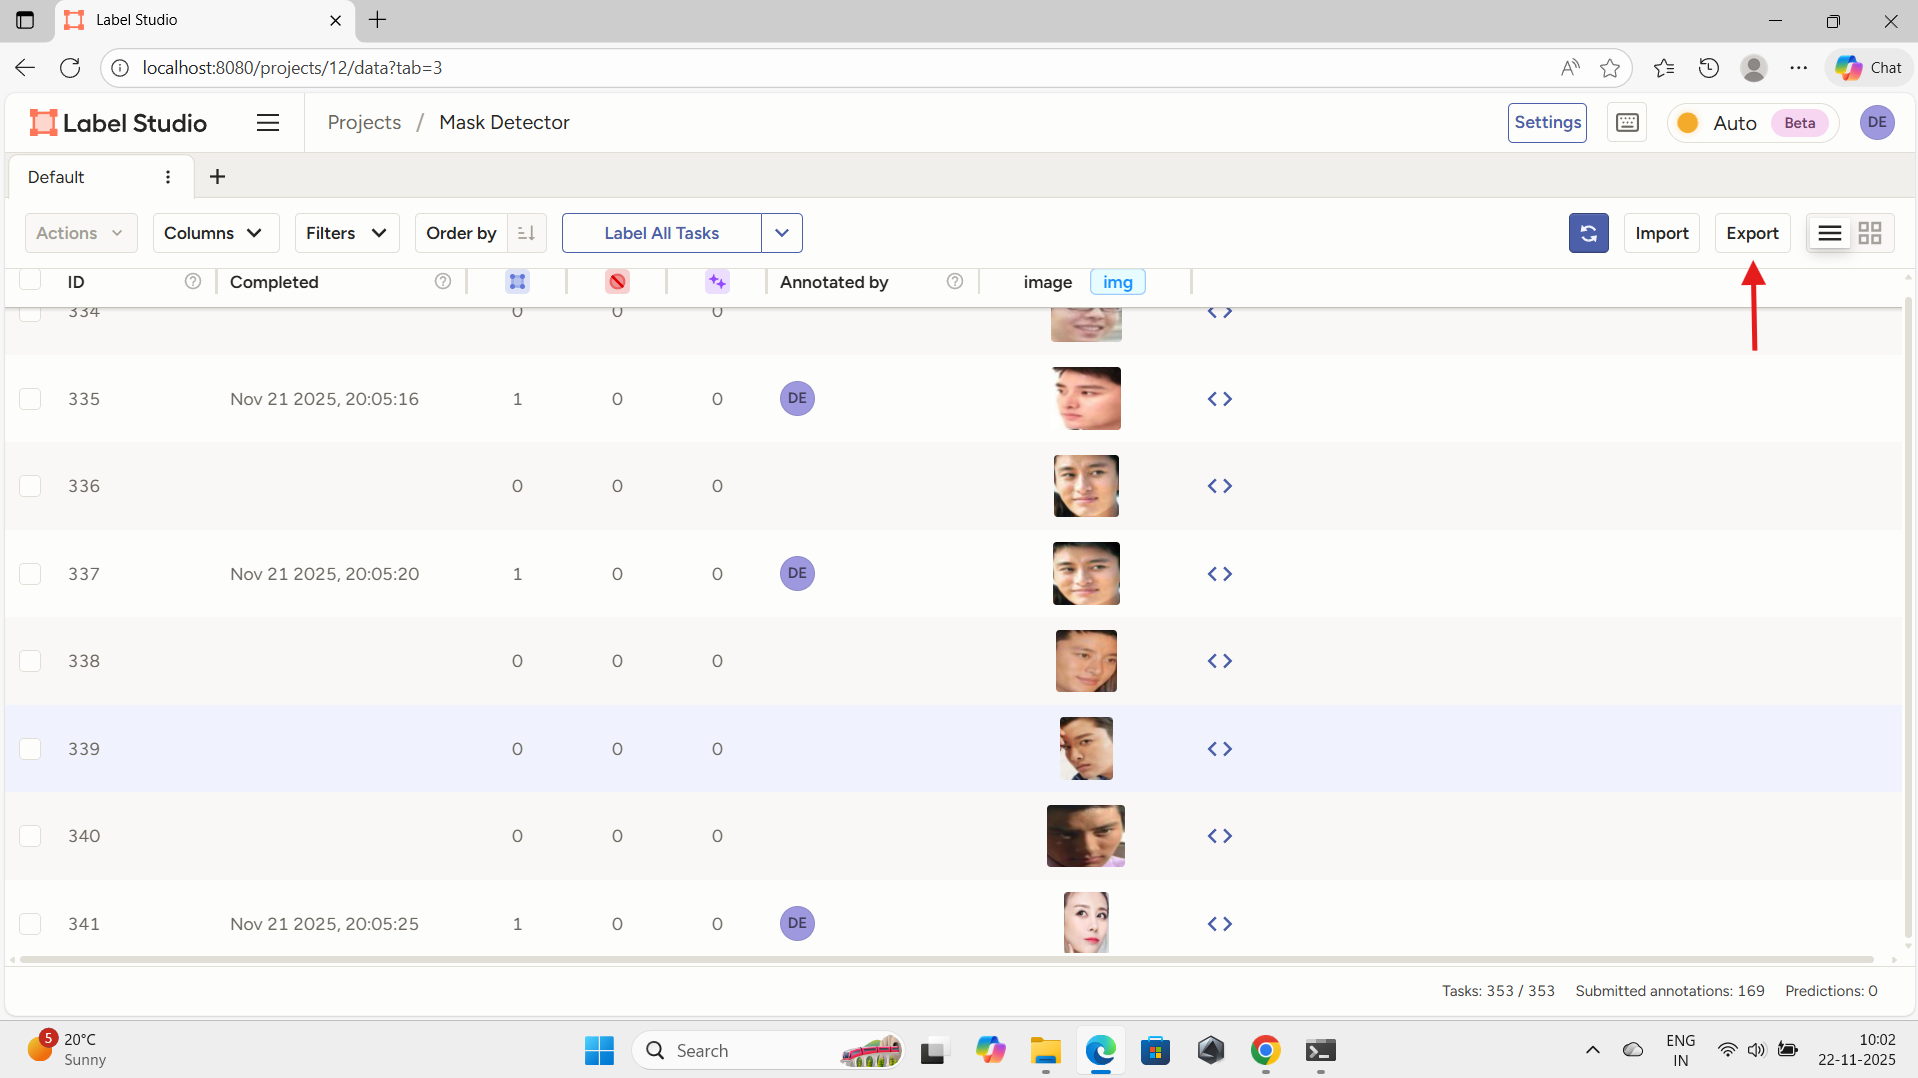

Download it in Yolo-11s or Yolo-v8 images according to your choice.



img1.png

After download dataset in zip file change the name of file to **data.zip** so that further code can execute easily,then drag and drop **data.zip** in **files** or click on files icon and attach your **data.zip** file to it.

img2.png

##Unziping the **data.zip**

This will create a custom_data that contain multiple folders, text and json file.

In [ ]:
!unzip -q /content/data.zip -d /content/custom_data

##Split images in training and validation

Ultralytics requires a particular folder structure to store training data for models. Ultralytics requires a particular folder structure to store training data for models. The root folder is named “data”. Inside, there are two main folders:

*   **Train**: These are the actual images used to train the model. In one epoch of training, every image in the train set is passed into the neural network. The training algorithm adjusts the network weights to fit the data in the images.


*   **Validation**: These images are used to check the model's performance at the end of each training epoch.

In [ ]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-11-21 18:09:09--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-11-21 18:09:09 (64.5 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Number of image files: 169
Number of annotation files: 169
Images moving to train: 152
Images moving to validation: 17


##Install Ultralytics


Next, we'll install the Ultralytics library in this Google Colab instance. This Python library will be used to train the YOLO model

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.7 MB/s eta 0:00:00


##Configure Training

There's one last step before we can run training: we need to create the Ultralytics training configuration YAML file. This file specifies the location of your train and validation data, and it also defines the model's classes.

Run the code block below to automatically generate a data.yaml configuration file. Make sure you have a labelmap file located at custom_data/classes.txt. If you used Label Studio or one of my pre-made datasets, it should already be present. If you assembled the dataset another way, you may have to manually create the classes.txt file

In [ ]:
import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 2
names:
- Mask
- NoMask


##Train Model

Run the following code block to begin training. If you want to use a different model, number of epochs, or resolution. You can change model to Yolov8 or Yolo-11s or you can change resolution according to your choice lower resloution gives higher accuracy,for images less than 200 epoches around 60 is considered,my images with label was around 200.

In [ ]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=60 imgsz=640

Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pret

##Test Model

The model has been trained; now it's time to test it! The commands below run the model on the images in the validation folder and then display the results for the first 10 images. This is a good way to confirm your model is working as expected. Click Play on the blocks below to see how your model performs.

In [ ]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

image 1/31 /content/data/validation/images/05e4f4e1-unmask_3.jpg: 576x640 1 NoMask, 52.4ms
image 2/31 /content/data/validation/images/175b5dc8-mask_2.png: 640x448 1 Mask, 50.3ms
image 3/31 /content/data/validation/images/25987b0e-mask_9.jpeg: 640x512 1 Mask, 50.5ms
image 4/31 /content/data/validation/images/2cb9182c-mask_19.jpeg: 640x640 1 Mask, 16.3ms
image 5/31 /content/data/validation/images/2e816eec-mask_3.JPEG: 640x544 1 Mask, 50.7ms
image 6/31 /content/data/validation/images/44b6effa-mask_120.jpg: 640x416 1 Mask, 50.5ms
image 7/31 /content/data/validation/images/4adffa45-mask_28.jpg: 640x416 1 Mask, 11.8ms
image 8/31 /content/data/validation/images/4e8d66ac-mask_154.jpg: 640x448 1 Mask, 12.6ms
image 9/31 /content/data/validation/images/5555fb8b-unmask_10.jpg: 608x640 1 NoMask, 51.4ms
image 10/31 /content/data/valid

In below test we are getting accuracy around 80-90 or even above 90 in some cases we can say our model is somewhat accurate.

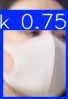

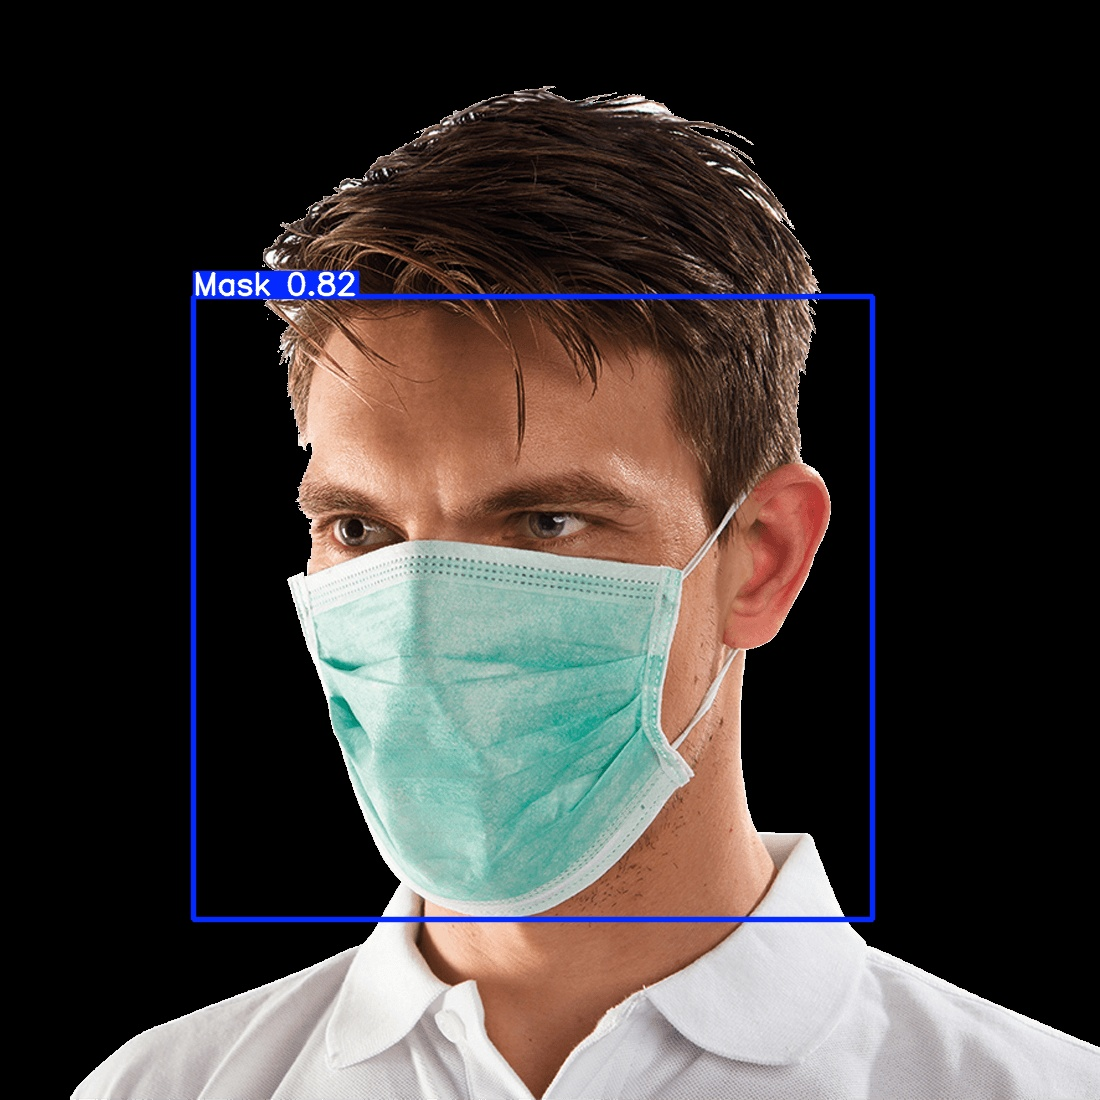

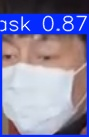

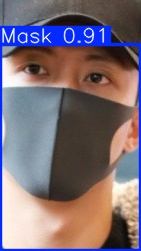

In [ ]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


##Deploy Model

Now that your custom model has been trained, it's ready to be downloaded and deployed in an application! YOLO models can run on a wide variety of hardware, including PCs, embedded systems, and phones. Ultralytics makes it easy to convert the YOLO models to various formats.

In [ ]:
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

##Download Yolo Model

First, zip and download the trained model by running the code blocks below.

In [ ]:
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

/content/my_model
  adding: my_model.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/BoxF1_curve.png (deflated 15%)
  adding: train/BoxP_curve.png (deflated 19%)
  adding: train/results.png (deflated 7%)
  adding: train/train_batch1.jpg (deflated 9%)
  adding: train/confusion_matrix.png (deflated 35%)
  adding: train/val_batch0_pred.jpg (deflated 16%)
  adding: train/train_batch552.jpg (deflated 15%)
  adding: train/train_batch550.jpg (deflated 15%)
  adding: train/labels.jpg (deflated 54%)
  adding: train/val_batch0_labels.jpg (deflated 17%)
  adding: train/train_batch0.jpg (deflated 7%)
  adding: train/train_batch2.jpg (deflated 8%)
  adding: train/results.csv (deflated 61%)
  adding: train/confusion_matrix_normalized.png (deflated 35%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/best.pt (deflated 8%)
  adding: train/weights/last.pt (deflated 8%)
  adding: train/BoxPR_curve.png (deflated 28%)
  adding: train/BoxR_curve.png (deflated 17%)
  adding: train

In [ ]:
from google.colab import files

files.download('/content/my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Deploy Model PC




First, Install Anaconda Contribution Installer in your PC and setup it by its default path.

After download , open anaconda prompt create a enviorment and activate it using the code below.

In [ ]:
conda create --name mask python=3.12

Then when download after completion execute below.

In [ ]:
activate mask

If you have nvidia gpu then you can install Gpu-enabled pytorch by executing below code.

In [ ]:
pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Extract the model.zip you download to folder.

Then in anaconda prompt select particular folder in which you have unzip the model.zip.

Copy the address of the folder where you unzipped it.

img3.png

In [ ]:
cd path/to/folder

Download yolo_detect.py from my github account.


https://github.com/vaibhav25mim10135-code/Mask-Detection.git

Finally time to execute the model

You can change source to image , video or web cam , also you can change  resolution biased on fps and accuracy depending on items present with you.

In [ ]:
python yolo_detect.py --model my_model.pt --source img.jpg --resolution 1280x720
                               or
python yolo_detect.py --model my_model.pt --source video.mp4 --resolution 1280x720
                               or
python yolo_detect.py --model my_model.pt --source usb0 --resolution 1280x720


After execution of code , a YOLO detection results will open up that will detect where a person in image or video or live stream is wearing mask or not.

img4.png